Nadaray-Watson

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

class NW:
    def __init__(self, X, Y, core):
        self.X = X
        self.Y = Y
        self.core = core
        self.h = self._find_h_opt(0.01, round((X.max() - X.min()) / 3), round((X.max() - X.min()) / X.shape[0], 2))

    def get_h_opt(self):
        return self.h

    def _dist(self, x, y):
        return math.sqrt((x - y)**2)

    def _find_h_opt(self, min_h, max_h, step_h):
        LOO_min = 50000
        arrayLOO = []
        arrayH = np.arange(min_h, max_h, step_h)
        for h in arrayH:
            LOO = self._LOO(h)
            arrayLOO.append(LOO)
            # print("LOO: " + str(LOO))
            # print("h: " + str(h))
            if LOO < LOO_min:
                LOO_min = LOO
                h_opt = h
        plt.figure()
        plt.plot(arrayH, arrayLOO, linewidth=2, color='blue')
        plt.xlabel('h')
        plt.ylabel('LOO')
        # print("h_opt: " + str(h_opt))
        # print("LOO_min: " + str(LOO_min))
        plt.title("График зависимости LOO от h (h_opt = %f)" % h_opt)
        plt.show()
        return h_opt

    def _LOO(self, h):
        LOO = 0
        for i in range(self.X.shape[0]):
            LOO = LOO + (self._a_h_for_LOO(self.X[i], np.delete(self.X, [i]), np.delete(self.Y, [i]), h, self.core) - self.Y[i])**2
        return LOO

    def _a_h_for_LOO(self, x, X, Y, h, core):
        numerator = 0
        denominator = 0
        for i in range(X.shape[0]):
            numerator = numerator + Y[i] * core(self._dist(x, X[i]) / h)
            denominator = denominator + core(self._dist(x, X[i]) / h)
        if denominator == 0:
            alpha = 0
            return alpha
        else:
            alpha = numerator / denominator
            return alpha

    def a_h(self, x):
        return self._a_h_for_LOO(x, self.X, self.Y, self.h, self.core)

    # Функционал качества
    def SSE(self):
        res = 0
        for i in range(self.X.shape[0]):
            res = res + (self.a_h(self.X[i]) - self.Y[i])**2
        return res

LOWESS

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import median

class NR:
    def __init__(self, X, Y, core):
        self.X = X
        self.Y = Y
        self.core = core
        self.h = 0.55
        self.deviation = 1000  # погрешность для подбора gamma (зависит от h)
        self.med_eps = 1  # медиана вариационного ряда ошибок (для gamma)
        self.gamma = [1]*self.X.shape[0]
        self._find_h_and_gamma(0.01, round((X.max() - X.min()) / 2), round((X.max() - X.min()) / X.shape[0], 2), self._quartic_core_modify)

    def get_h_opt(self):
        return self.h

    def _dist(self, x, y):
        return math.sqrt((x - y)**2)

    def _quartic_core_modify(self, x):
        x = x / (6 * self.med_eps)
        if abs(x) <= 1:
            return (1 - x*x)**2
        else:
            return 0

    def _calculation_gamma(self, gamma, h, core):
        alpha = []
        eps = []
        # print("gamma_prev: " + str(gamma))
        for i in range(self.X.shape[0]):
            alpha.append(self._a_h_for_LOO(self.X[i], np.delete(self.X, [i]), np.delete(self.Y, [i]), np.delete(gamma, [i]), h, core))
            gamma[i] = core(abs(alpha[i] - self.Y[i]))
            eps.append(alpha[i] - self.Y[i])
        self.med_eps = median(eps)
        # print("gamma_cur: " + str(gamma))
        return

    def _find_h_and_gamma(self, min_h, max_h, step_h, core_gammas):
        LOO_min = 30000
        arrayLOO = []
        arrayH = np.arange(min_h, max_h, step_h)
        for h in arrayH:
            #print("h: " + str(h))
            gamma = [1]*self.X.shape[0]
            curGamma = list(gamma)
            self._calculation_gamma(gamma, h, core_gammas)
            while(abs(self._LOO(gamma, h) - self._LOO(curGamma, h)) >= self.deviation):
                curGamma = list(gamma)
                self._calculation_gamma(gamma, h, core_gammas)
            LOO = self._LOO(gamma, h)
            # print("LOO: " + str(LOO))
            arrayLOO.append(LOO)
            if LOO < LOO_min:
                LOO_min = LOO
                self.h = h
                self.gamma = gamma
        plt.figure()
        plt.plot(arrayH, arrayLOO, linewidth=2, color='blue')
        plt.xlabel('h')
        plt.ylabel('LOO')
        #print("h_opt: " + str(self.h))
        #print("LOO_min: " + str(LOO_min))
        # print("gamma: " + str(gamma))
        plt.title("График зависимости LOO от h (h_opt = %f)" % self.h)
        plt.show()
        return

    def _LOO(self, gamma, h):
        LOO = 0
        for i in range(self.X.shape[0]):
            LOO = LOO + (self._a_h_for_LOO(self.X[i], np.delete(self.X, [i]), np.delete(self.Y, [i]), np.delete(gamma, [i]), h, self.core) - self.Y[i])**2
        #print("LOO: " + str(LOO))
        return LOO

    def _a_h_for_LOO(self, x, X, Y, gamma, h, core):
        numerator = 0
        denominator = 0
        for i in range(X.shape[0]):
            numerator = numerator + Y[i] * gamma[i] * core(self._dist(x, X[i]) / h)
            denominator = denominator + gamma[i] * core(self._dist(x, X[i]) / h)
        if denominator == 0:
            alpha = 0
            return alpha
        else:
            alpha = numerator / denominator
            return alpha

    # Классификация в одной точке выборки
    def a_h(self, x):
        return self._a_h_for_LOO(x, self.X, self.Y, self.gamma, self.h, self.core)

    # Функционал качества
    def SSE(self):
        res = 0
        for i in range(self.X.shape[0]):
            res = res + (self.a_h(self.X[i]) - self.Y[i])**2
        return res

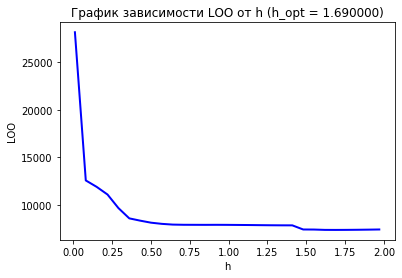

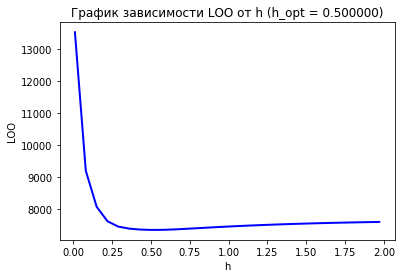

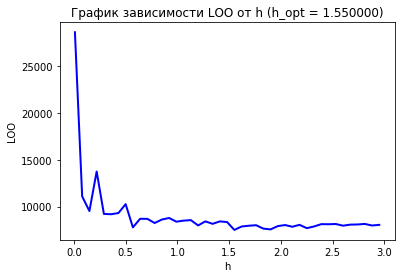

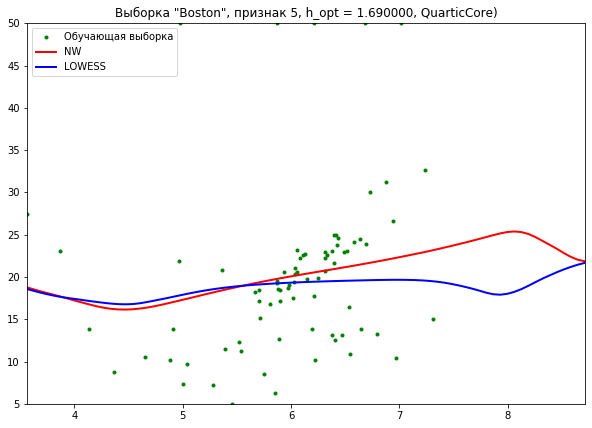

SSE для QuarticCore NW: 6950.076382252671
SSE для GaussCore NW: 6765.908378290097


In [26]:

from sklearn import datasets

def QuarticCore(x):
    if abs(x) <= 1:
        return (1 - x*x)**2
    else:
        return 0

def GaussCore(x):
    return (1/math.sqrt(2*math.pi)) * math.exp((-0.5)*x*x)

# Номер признака (RM)
j = 5
X = datasets.load_boston().data[:, j]
# Стоимость жилья
Y = datasets.load_boston().target

# Задание подвыборки выборки Boston
first = 320
last = 400
X = X[first:last]
Y = Y[first:last]
core = QuarticCore
# Создание объекта класса NW
nw = NW(X, Y, core)
nwg = NW(X, Y, GaussCore)
nr = NR(X, Y, core)
step = (X.max() - X.min()) / X.shape[0]

# Массив всех x из X с шагом step
array = np.arange(X.min(), X.max(), step)

# Создание и отрисовка сетки XxY
plt.figure(figsize=(10,7))
plt.xlim(array.min(), array.max())
plt.ylim(Y.min(), Y.max())
plt.plot(X, Y, 'ro', markersize=3, color='green')

# Заполнение оптимального вектора параметров модели alpha
alpha = []
alpha1 = []
for x in array:
    alpha.append(nw.a_h(x))
    alpha1.append(nr.a_h(x))

# Отрисовка обучающей выборки и линии регрессии
plt.plot(array, alpha, linewidth=2, color='red')
plt.plot(array, alpha1, linewidth=2, color='blue')
plt.title("Выборка \"Boston\", признак %i, h_opt = %f, QuarticCore)" % (j, nw.get_h_opt()))
plt.legend(('Обучающая выборка', 'NW','LOWESS'), loc='upper left')
plt.show()

print("SSE для QuarticCore NW: " + str(nw.SSE()))
print("SSE для GaussCore NW: " + str(nwg.SSE()))